In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json
import re
from sklearn.pipeline import Pipeline
import ast
from google.colab import drive
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing and Cleaning

In [ ]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/storygraph2.csv')

In [ ]:
# Converting Moods column to dictionary
df['Moods'] = df['Moods'].apply(lambda x: ast.literal_eval(x))

# Removing commas from 'Number of Reviews' column
df['Number of Reviews'] = df['Number of Reviews'].str.replace(',', '')

# Splitting categories into words and creating new columns
all_categories = set()
for categories in df['Categories']:
    for category in categories.split(','):
        all_categories.add(category.strip())

# Creating new columns for each category
for category in all_categories:
    df[category] = df['Categories'].apply(lambda x: 1 if category in x.split(', ') else 0)

# Displaying the dataframe to verify if the category columns are set correctly
df.head(), all_categories

# Converting Publication Date to numeric format
df['Publication Date'] = pd.to_datetime(df['Publication Date'], format='%d %B %Y', errors='coerce').dt.strftime('%m/%d/%Y')

# Removing rows with NaN in Publication Date
df = df.dropna(subset=['Publication Date'])

# Removing unnecessary columns
df.drop(['Language'], axis=1, inplace=True)

# Expanding moods to separate columns
moods = set()
for mood in df['Moods']:
    moods.update(mood.keys())

for mood in moods:
    df[mood.lower()] = df['Moods'].apply(lambda x: int(x.get(mood, 0)[:-1]) if mood in x else 0)

# Dropping original mood column
df.drop(['Moods'], axis=1, inplace=True)

# Converting 'Pace' column to dictionary
df['Pace'] = df['Pace'].apply(lambda x: eval(x))

# Dropping columns we replaced
df.drop(['Categories'], axis=1, inplace=True)
df.drop(['Pace'], axis=1, inplace=True)
df.drop(['slow'], axis=1, inplace=True)
df.drop(['medium'], axis=1, inplace=True)
df.drop(['fast'], axis=1, inplace=True)
df.drop(['Discription'], axis=1, inplace=True)

                          Graphic CW  \
0        War, Death of parent, Death   
1       Gun violence, Death, Suicide   
2              Sexual content, Grief   
3  Fatphobia, Body shaming, Misogyny   
4            Murder, Death, Drug use   

                                Moderate CW                     Minor CW  
0   Alcoholism, Injury/Injury detail, Blood               Sexual content  
1  Car accident, Death of parent, Pregnancy                     Abortion  
2                                   Alcohol                          War  
3          Suicide, Sexism, Death of parent  Eating disorder, Pedophilia  
4        Animal death, Rape, Sexual assault                    Self harm  


<ipython-input-31-dbd9a307d6e0>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Language'], axis=1, inplace=True)
<ipython-input-31-dbd9a307d6e0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[mood.lower()] = df['Moods'].apply(lambda x: int(x.get(mood, 0)[:-1]) if mood in x else 0)
<ipython-input-31-dbd9a307d6e0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
# Save processed data to a CSV file
df.to_csv('/content/drive/MyDrive/storygraph_dataset(No Discription).csv', index=False)

print("Data processed and saved successfully.")

Data processed and saved successfully.


In [ ]:
# Load the dataset
books_df = pd.read_csv('/content/drive/MyDrive/storygraph_dataset(No Description).csv')

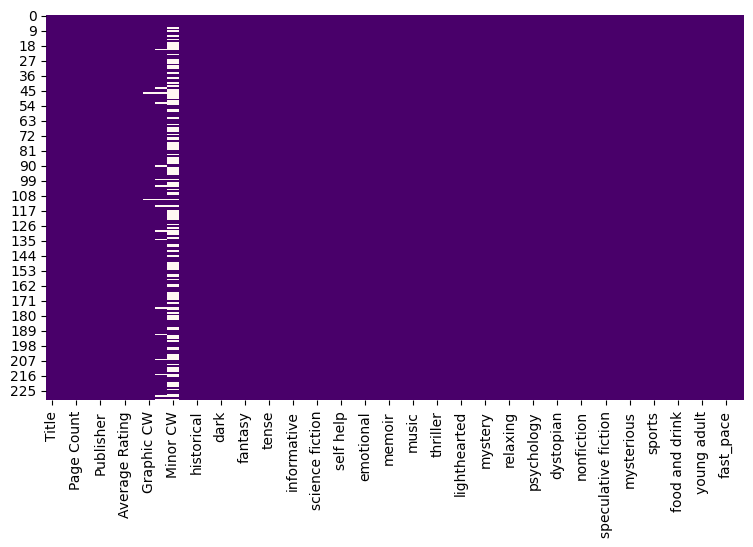

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(books_df.isnull(), cbar=False, cmap="RdPu_r")
plt.show()

In [ ]:
# creating a new Series 'total' that sums the number of empyt cells 'NA' in each column
# The result is then sorted from highest to lowest
total = books_df.isnull().sum().sort_values(ascending=False)
# Now, we get calculate the percentage and sort the values in 'percent' we can't remove the is null from count, we need something to make it go through the df
percent = (books_df.isnull().sum()/books_df.isnull().count()*100).sort_values(ascending=False)
#Now, we concat the two Serieses (total, percent) in a new DataFrame and we print the top 3
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data.head(3)

,Total,%
Minor CW,124,53.679654
Moderate CW,17,7.359307
Graphic CW,2,0.865801


We can see that there are some null values in all CW columns, we can fill them with NA

In [ ]:
NotApplicable = 'N/A'
data = [books_df]
CW_columns = ['Graphic CW', 'Moderate CW', 'Minor CW']

for dataset in data:
    dataset[CW_columns] = dataset[CW_columns].fillna(NotApplicable)

In [ ]:
books_df['Graphic CW'].isnull().sum()

0

In [ ]:
books_df['Moderate CW'].isnull().sum()

0

In [ ]:
books_df['Minor CW'].isnull().sum()

0

No more nulls! we can move on to EDA

# Exploratory Data Analysis (EDA)

## Overview

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                231 non-null    object 
 1   Author               231 non-null    object 
 2   Page Count           231 non-null    int64  
 3   Format               231 non-null    object 
 4   Publisher            231 non-null    object 
 5   Publication Date     231 non-null    object 
 6   Average Rating       231 non-null    float64
 7   Number of Reviews    231 non-null    int64  
 8   Graphic CW           231 non-null    object 
 9   Moderate CW          231 non-null    object 
 10  Minor CW             231 non-null    object 
 11  literary             231 non-null    int64  
 12  historical           231 non-null    int64  
 13  horror               231 non-null    int64  
 14  dark                 231 non-null    int64  
 15  magical realism      231 non-null    int

In [ ]:
books_df.describe()

,Page Count,Average Rating,Number of Reviews,literary,historical,horror,dark,magical realism,fantasy,medium-paced,...,mysterious,reflective,sports,middle grade,food and drink,funny,young adult,medium_pace,fast_pace,slow_pace
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,...,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,407.956710,4.129177,65758.337662,0.242424,0.112554,0.017316,38.402597,0.017316,0.389610,0.787879,...,33.350649,23.965368,0.012987,0.008658,0.004329,26.874459,0.186147,56.000000,29.385281,13.116883
std,162.273756,0.260668,68699.638576,0.429480,0.316733,0.130729,31.663829,0.130729,0.488721,0.409698,...,31.266637,23.149958,0.113464,0.092846,0.065795,26.758774,0.390071,11.909076,16.664817,12.997633
min,11.000000,3.180000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,2.000000,1.000000
25%,325.000000,3.965000,12338.500000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,...,3.000000,5.000000,0.000000,0.000000,0.000000,6.000000,0.000000,50.000000,17.500000,4.000000
50%,377.000000,4.140000,43244.000000,0.000000,0.000000,0.000000,35.000000,0.000000,0.000000,1.000000,...,26.000000,13.000000,0.000000,0.000000,0.000000,16.000000,0.000000,59.000000,27.000000,9.000000
75%,438.000000,4.300000,92183.000000,0.000000,0.000000,0.000000,62.000000,0.000000,1.000000,1.000000,...,58.000000,39.000000,0.000000,0.000000,0.000000,46.000000,0.000000,65.000000,38.500000,16.000000
max,1276.000000,4.670000,337001.000000,1.000000,1.000000,1.000000,99.000000,1.000000,1.000000,1.000000,...,98.000000,85.000000,1.000000,1.000000,1.000000,90.000000,1.000000,74.000000,81.000000,66.000000


In [ ]:
books_df.describe(include=['O'])

,Title,Author,Format,Publisher,Publication Date,Graphic CW,Moderate CW,Minor CW
count,101,101,101,101,101,101,101,101
unique,101,78,4,66,55,95,99,74
top,Divine Rivals,Sarah J. Maas,Hardcover,Tor Books,2024-04,"Sexual content, Grief",Alcohol,Pregnancy
freq,1,7,56,6,12,2,2,5


## Visulazations of All Columns

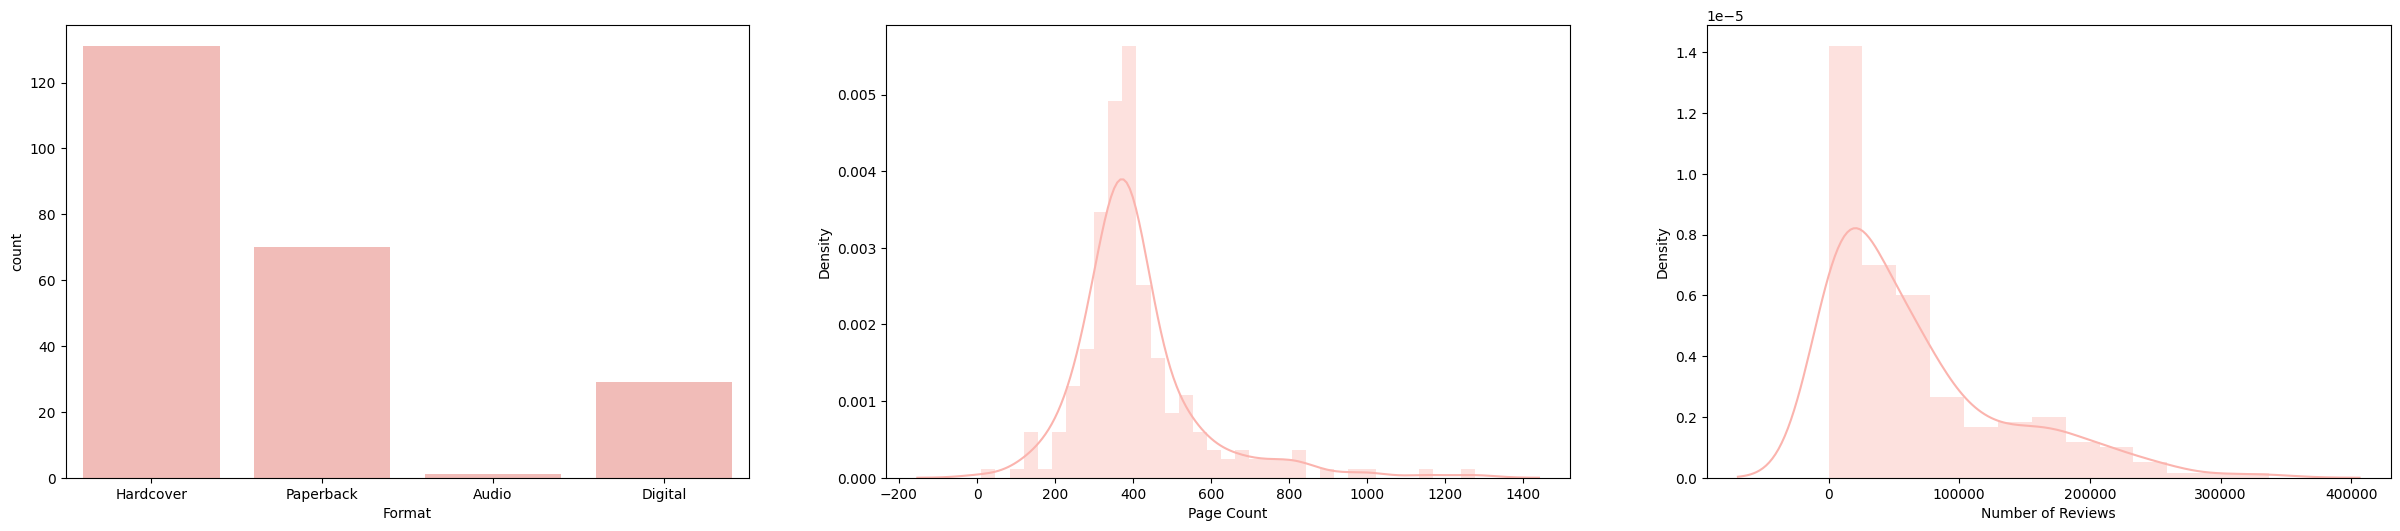

In [ ]:
categ_features =  [ 'Format']
conti_features = ['Page Count', 'Number of Reviews']

#Distribution
sns.set_palette("Pastel1")
fig = plt.figure(figsize=(30, 20))

for i in range (0,len(categ_features)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ_features[i], data=books_df)

for col in conti_features:
    fig.add_subplot(3,3,i + 2)
    sns.distplot(books_df[col].dropna())
    i += 1

plt.show();

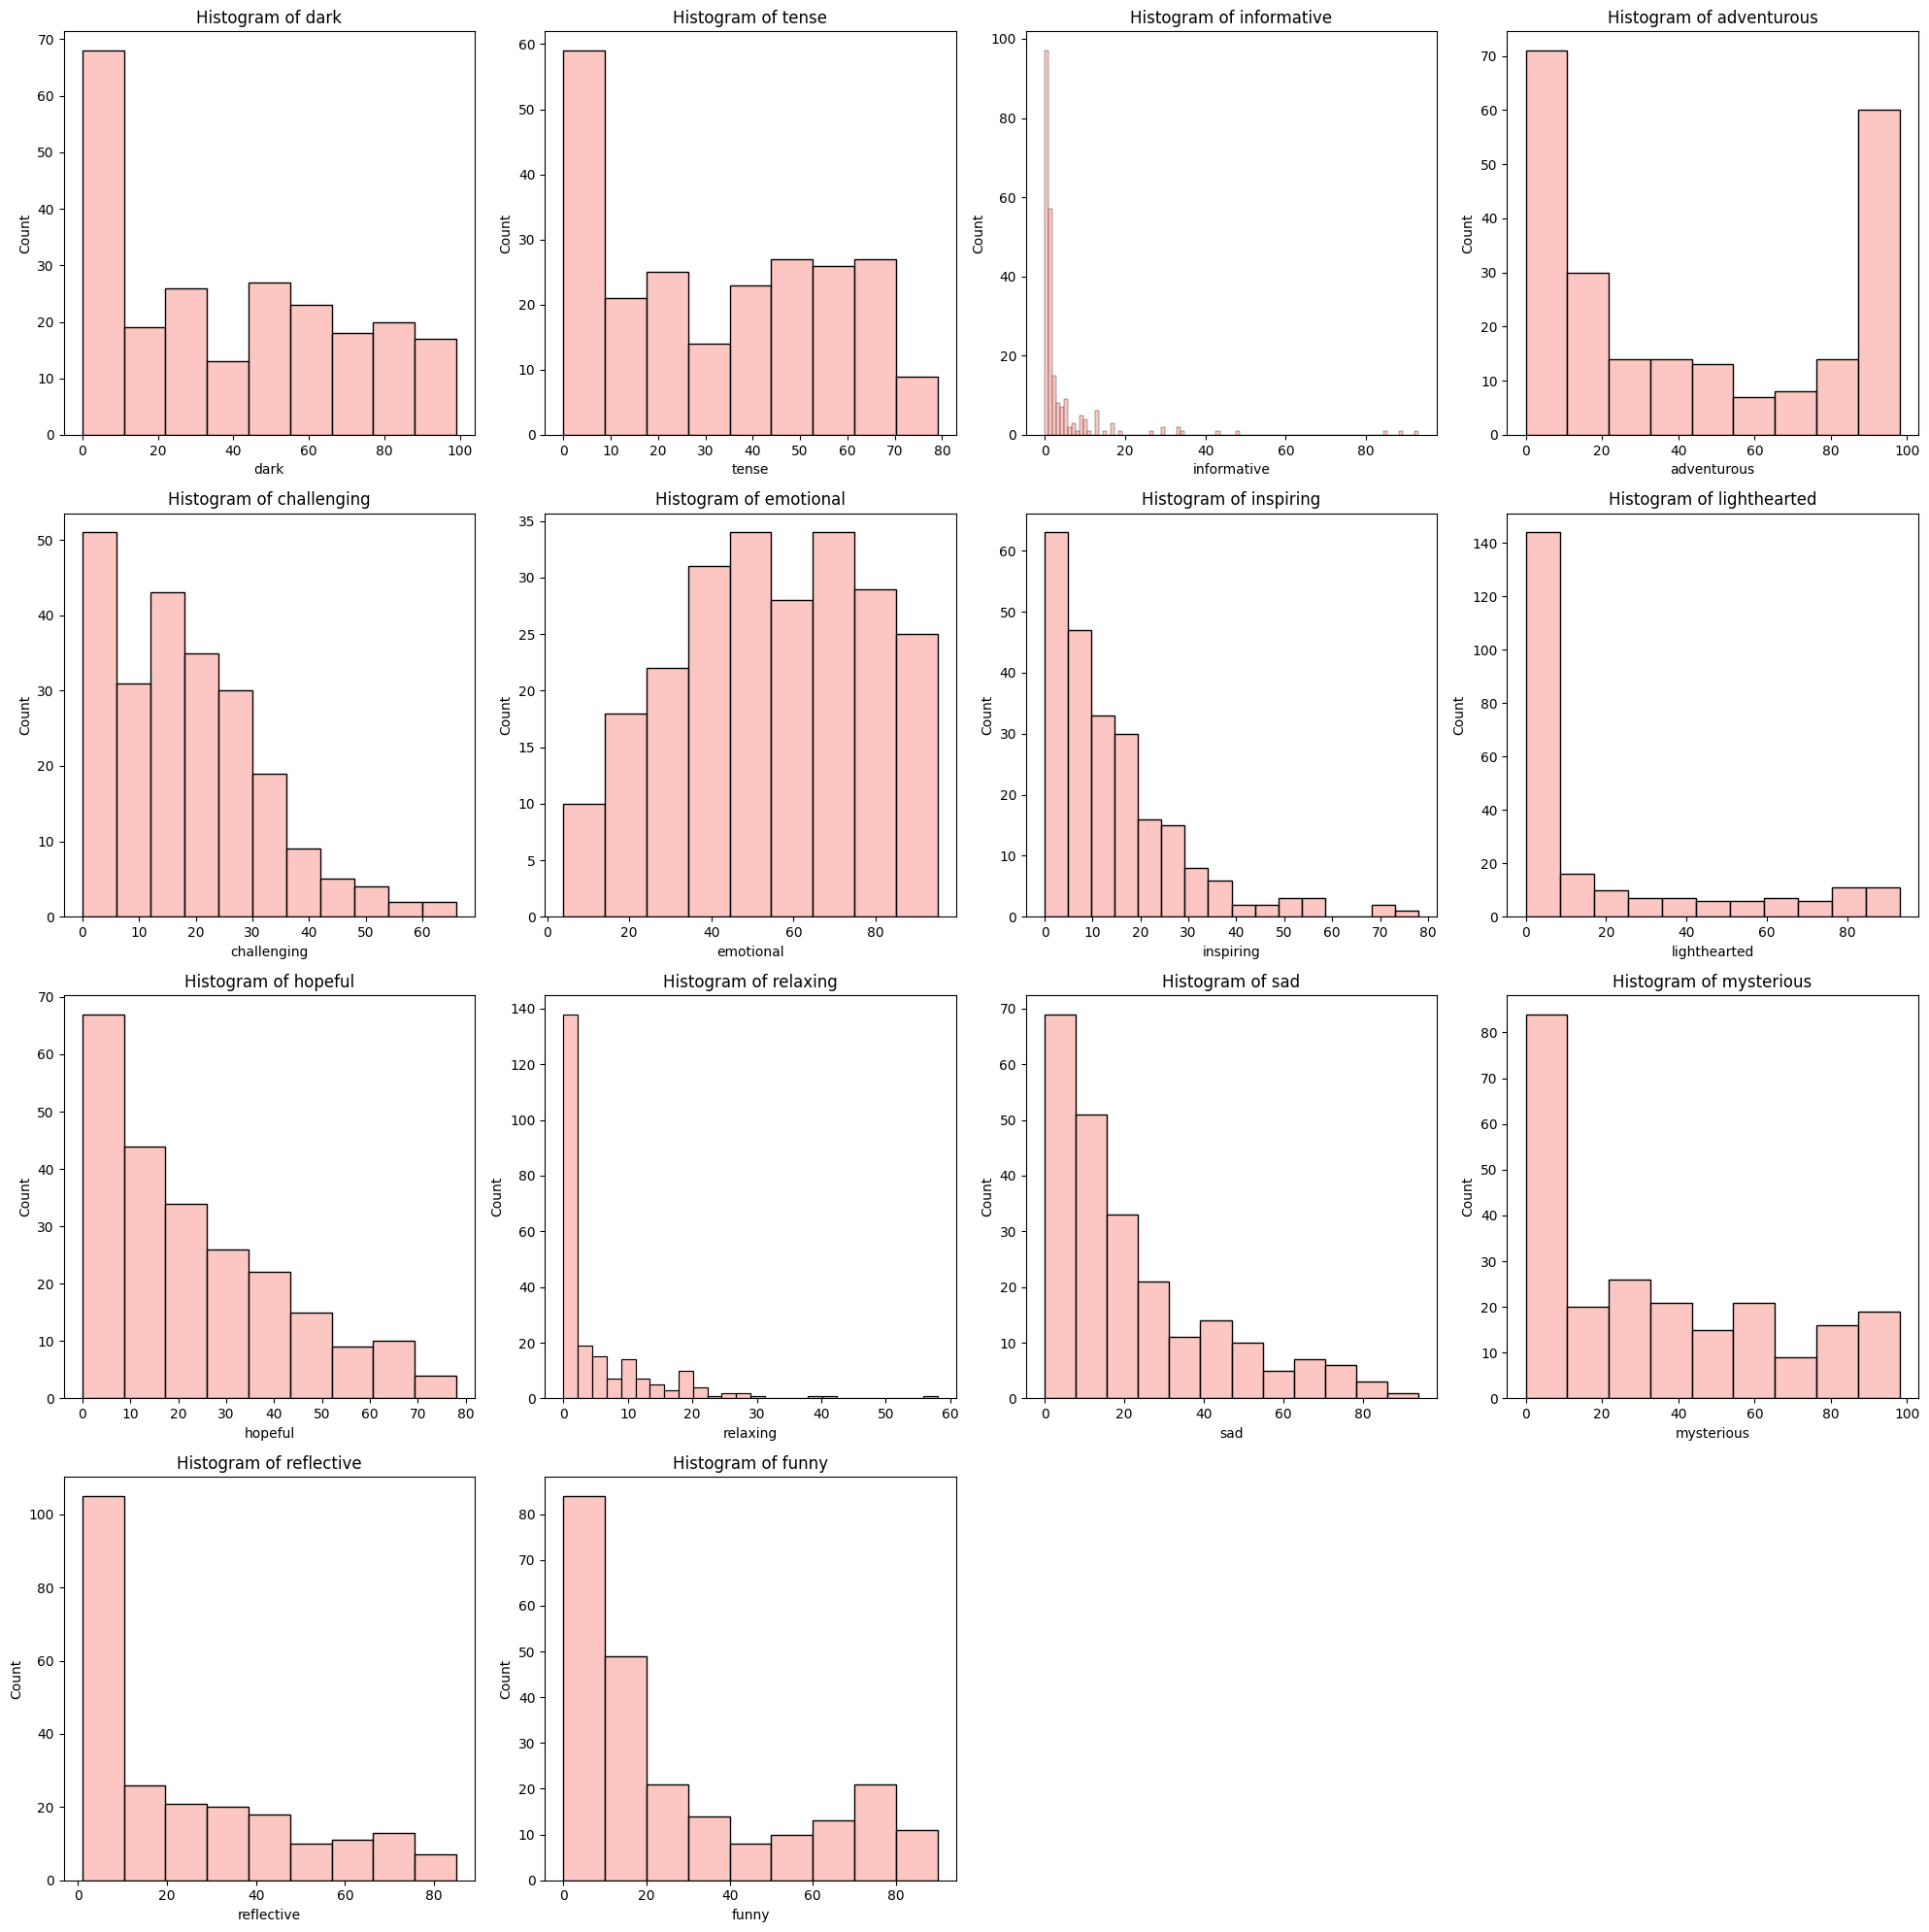

In [ ]:
moods_features = ['dark', 'tense', 'informative', 'adventurous', 'challenging', 'emotional', 'inspiring', 'lighthearted', 'hopeful', 'relaxing', 'sad', 'mysterious', 'reflective', 'funny']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for i, mood_feature in enumerate(moods_features):
    ax = axes[i]
    sns.histplot(data=books_df, x=mood_feature, ax=ax)
    ax.set_title(f'Histogram of {mood_feature} mood')
# Remove empty subplots
for i in range(len(moods_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

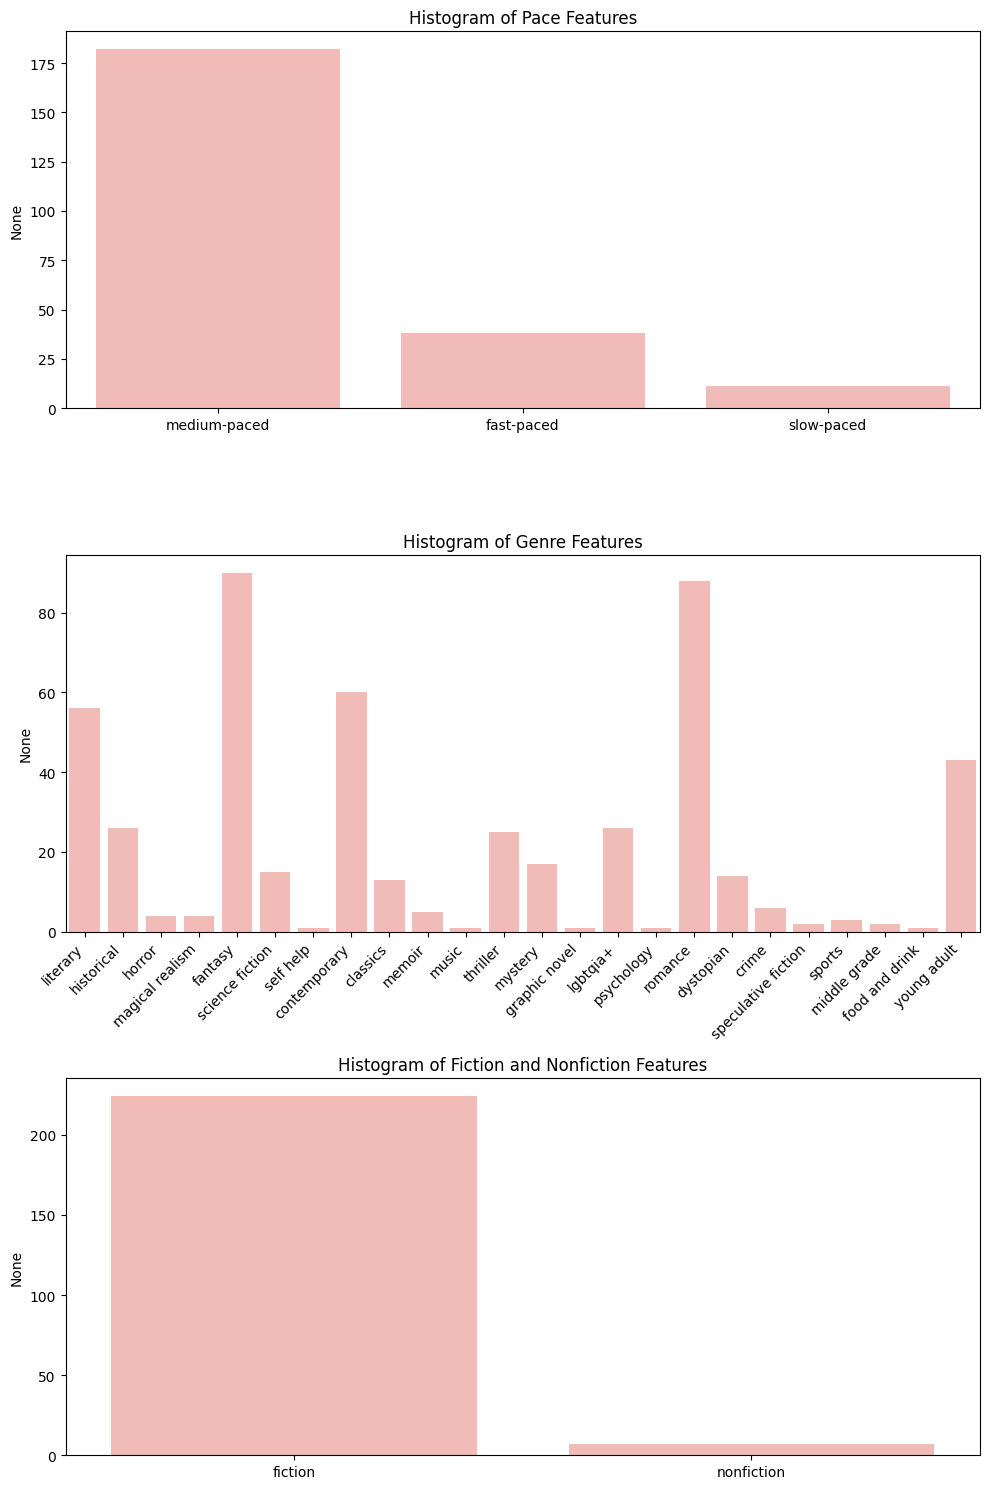

In [ ]:
pace_features = ['medium-paced', 'fast-paced', 'slow-paced']
genre_features = ['literary', 'historical', 'horror', 'magical realism', 'fantasy', 'science fiction', 'self help', 'contemporary', 'classics', 'memoir', 'music', 'thriller', 'mystery', 'graphic novel', 'lgbtqia+', 'psychology', 'romance', 'dystopian', 'crime', 'speculative fiction', 'sports', 'middle grade', 'food and drink', 'young adult']
fic_nonfic_features = ['fiction', 'nonfiction']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot histograms for pace features
ax = axes[0]
sns.barplot(x=pace_features, y=books_df[pace_features].sum(), ax=ax)
ax.set_title('Histogram of Pace Features')

# Plot histograms for genre features
ax = axes[1]
sns.barplot(x=genre_features, y=books_df[genre_features].sum(), ax=ax)
ax.set_title('Histogram of Genre Features')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Plot histograms for fiction and nonfiction features
ax = axes[2]
sns.barplot(x=fic_nonfic_features, y=books_df[fic_nonfic_features].sum(), ax=ax)
ax.set_title('Histogram of Fiction and Nonfiction Features')

plt.tight_layout()
plt.show()

## Analysis for testing the diversity and balance of data

- Diversity of the year

In [ ]:
# Calculate the proportion of books published each year
year_counts = books_df['publication year'].value_counts(normalize=True)

# Calculate the Gini-Simpson Index
gini_simpson_index = 1 - sum(year_counts**2)
gini_simpson_index

0.8773649642191942

- Diversity of the language

In [ ]:
# Calculate entropy on year proportions
entropy = -sum(year_counts * np.log2(year_counts))
entropy

3.554788102919387

- The frequancy of each value in author, genre, publisher, and publication year

In [ ]:
# Calculate potential biases
author_bias = books_df['Author'].value_counts()
publisher_bias = books_df['Publisher'].value_counts()
publication_year_bias = books_df['publication year'].value_counts()

# Evaluation of biases and their sources
biases_evaluation = {
    "Author Bias": author_bias,
    "Publisher Bias": publisher_bias,
    "Publication Year Bias": publication_year_bias
}
print(biases_evaluation)

{'Author Bias': Author
 Sarah J. Maas        7
 Ali Hazelwood        3
 Stephanie Garber     3
 Suzanne Collins      3
 Brandon Sanderson    2
                     ..
 Ottessa Moshfegh     1
 Gabrielle Zevin      1
 Cormac McCarthy      1
 Julia Quinn          1
 Jaden Payne          1
Name: count, Length: 78, dtype: int64, 'Publisher Bias': Publisher
Tor Books                  6
Berkley                    6
Flatiron Books             5
Atria Books                4
Wednesday Books            3
                          ..
VERVE Books                1
Ecco Press                 1
Alfred A. Knopf            1
Ace Books                  1
Indipendently Published    1
Name: count, Length: 66, dtype: int64, 'Publication Year Bias': publication year
2024    22
2023    20
2022    13
2021     9
2019     6
2017     4
2004     4
2014     4
2013     3
2016     2
2018     2
2006     2
2003     2
2020     1
2011     1
2015     1
2008     1
2002     1
2012     1
2010     1
2009     1
Name: count, dt

## Studying Correlations

In [ ]:
selected_columns = ['Page Count', 'Average Rating']
correlation_matrix = books_df[selected_columns].corr()
print(correlation_matrix)

                Page Count  Average Rating
Page Count        1.000000        0.205491
Average Rating    0.205491        1.000000


<Axes: >

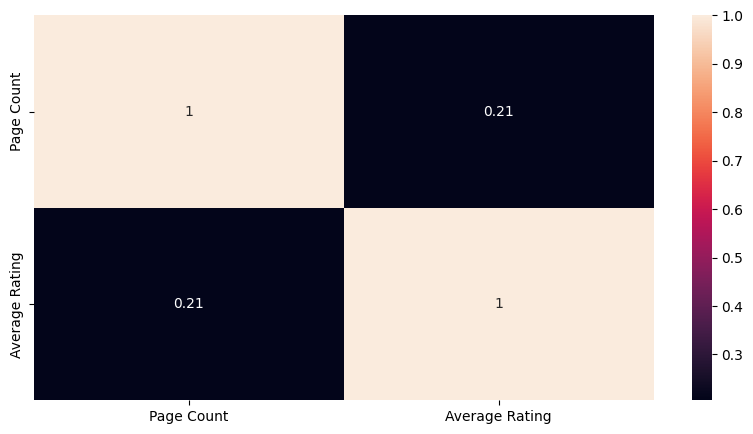

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix, annot=True)

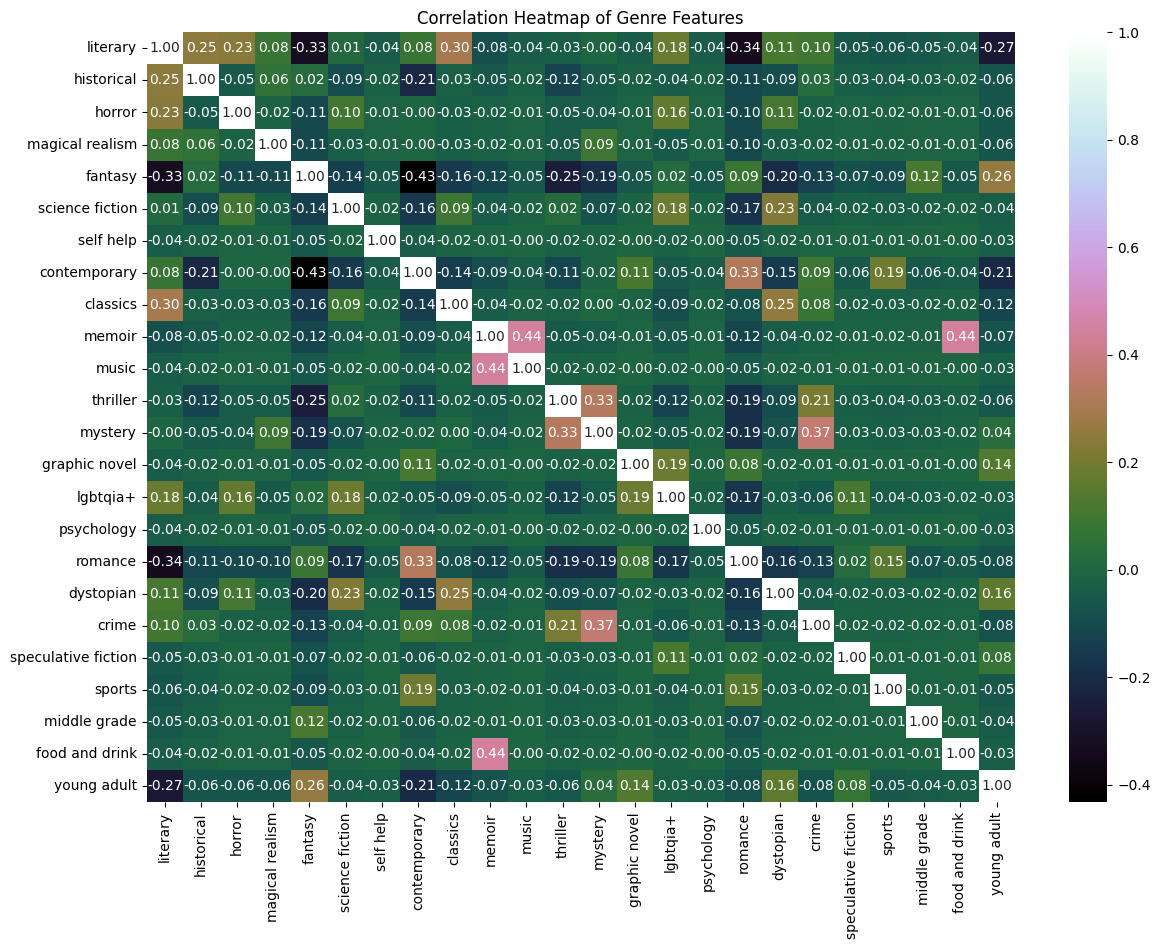

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(books_df[genre_features].corr(), annot=True, cmap='cubehelix', fmt=".2f")
plt.title('Correlation Heatmap of Genre Features')
plt.show()

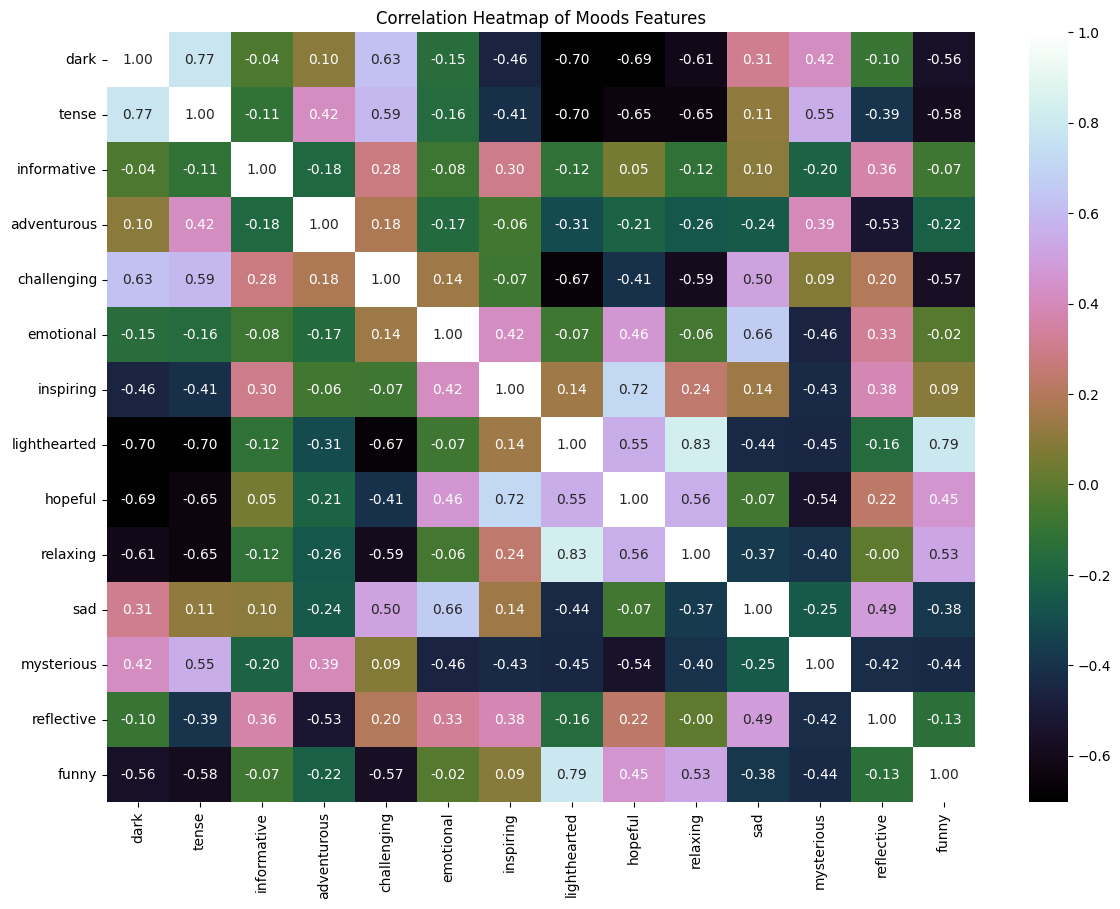

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(books_df[moods_features].corr(), annot=True, cmap='cubehelix', fmt=".2f")
plt.title('Correlation Heatmap of Moods Features')
plt.show()

## Studying the Relation of Some Features Against 'Average Rating'

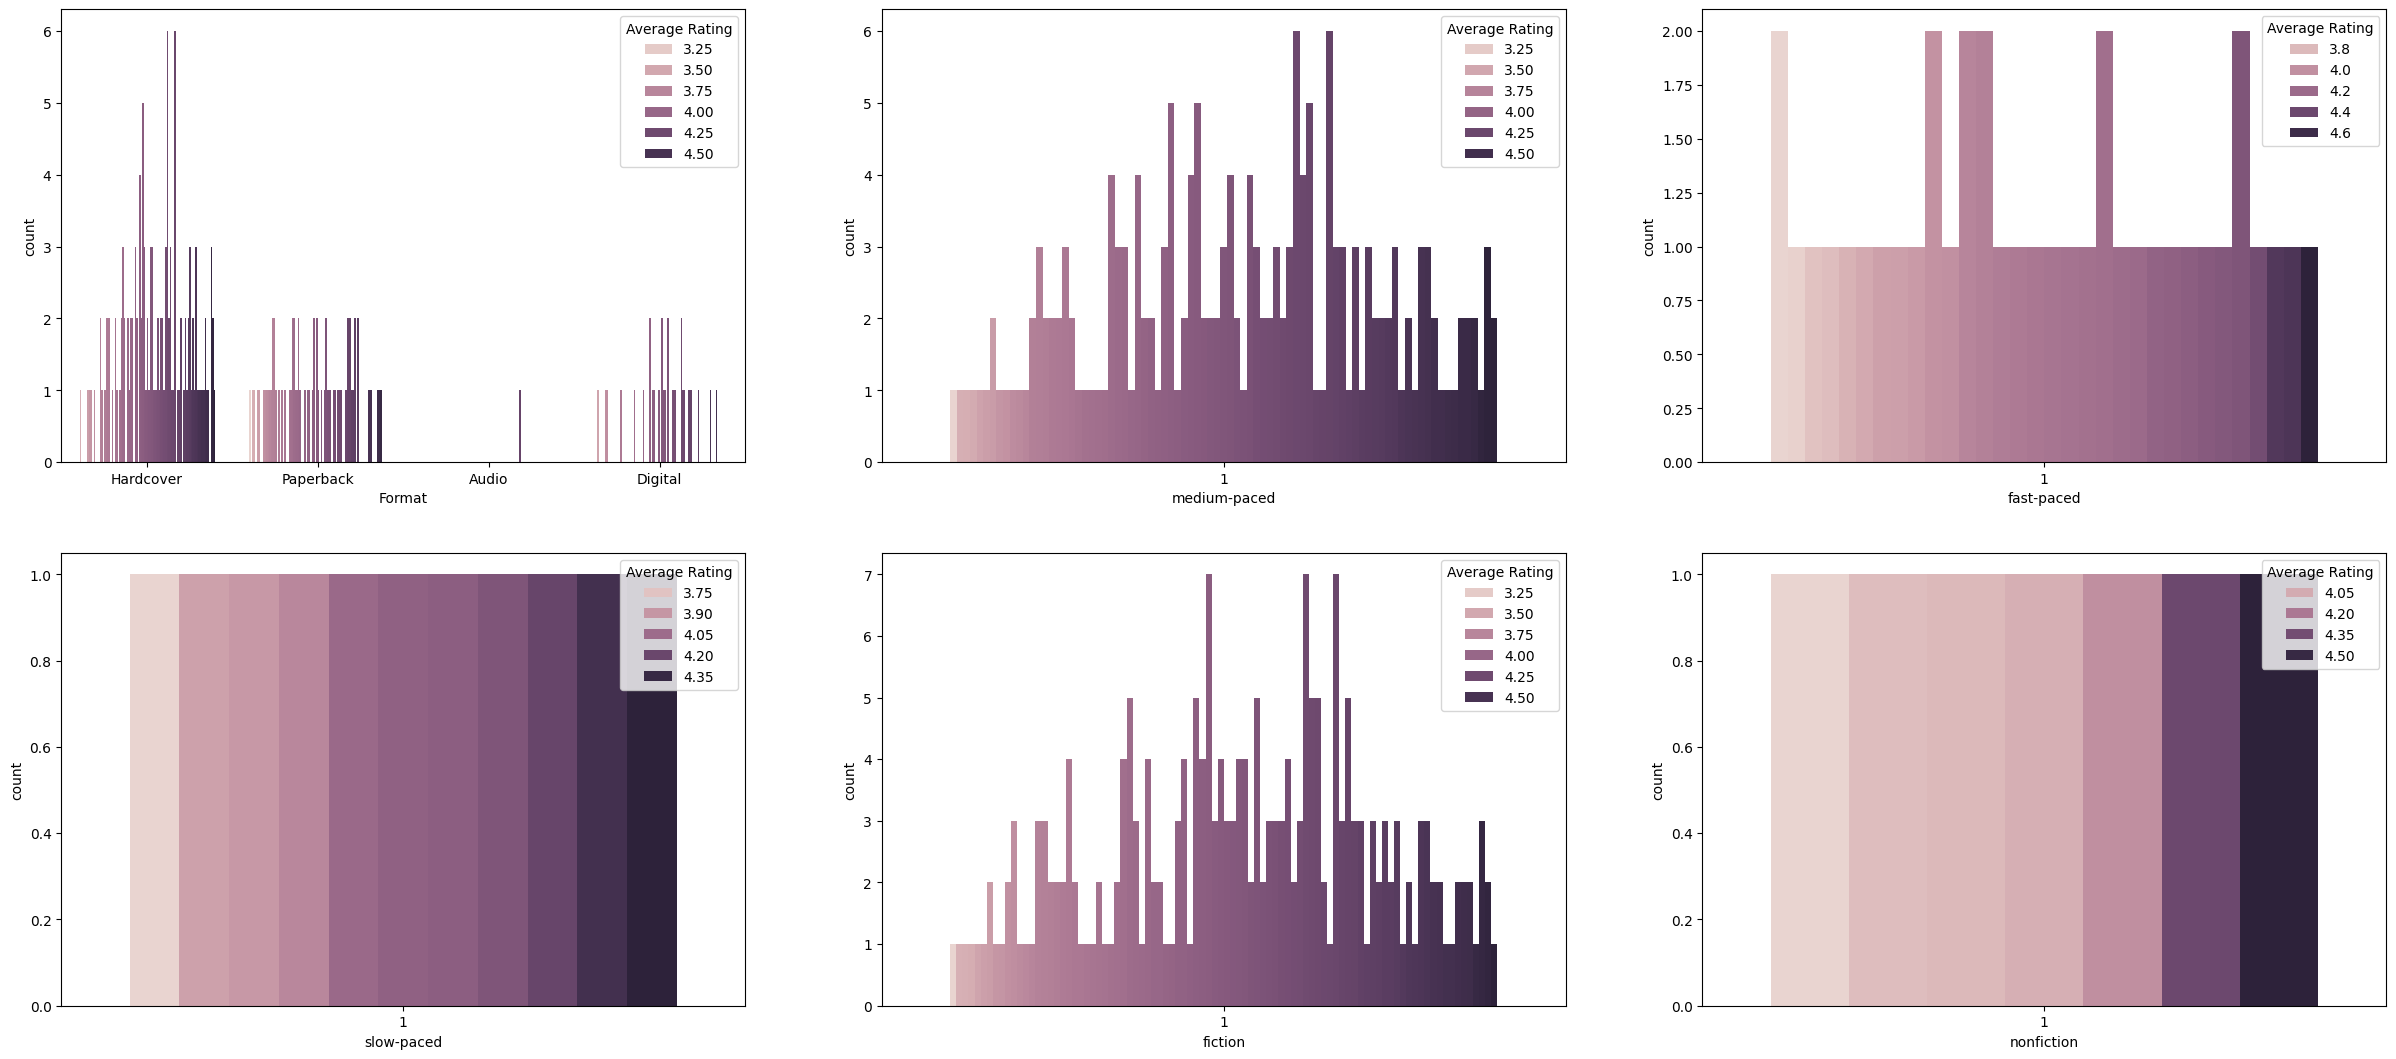

In [ ]:
fig = plt.figure(figsize=(30, 20))
i = 1
for col in categ_features:
    if col != 'Average Rating':
        fig.add_subplot(3,3,i)
        sns.countplot(x=col, data=books_df,hue='Average Rating');
        i += 1

for col in pace_features:
    if col != 'Average Rating':
        filtered_df = books_df[books_df[col] == 1]
        fig.add_subplot(3, 3, i)
        sns.countplot(x=col, data=filtered_df, hue='Average Rating')
        i += 1

for col in fic_nonfic_features:
    if col != 'Average Rating':
        filtered_df = books_df[books_df[col] == 1]
        fig.add_subplot(3, 3, i)
        sns.countplot(x=col, data=filtered_df, hue='Average Rating')
        i += 1

plt.show()

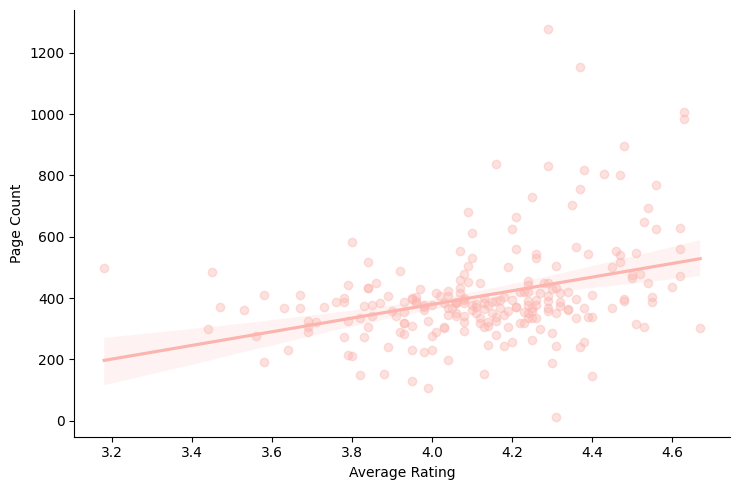

In [ ]:
sns.lmplot(x='Average Rating', y='Page Count', data=books_df, aspect=1.5, scatter_kws={'alpha':0.4})

## Most Occuring Values

- The Author with biggest number of books

In [ ]:
occu=df_clean['Author'].value_counts()
most_common_author = occu.idxmax()
print(most_common_author)

most_common_count = occu.max()
print(most_common_count)

 Sarah J. Maas
7


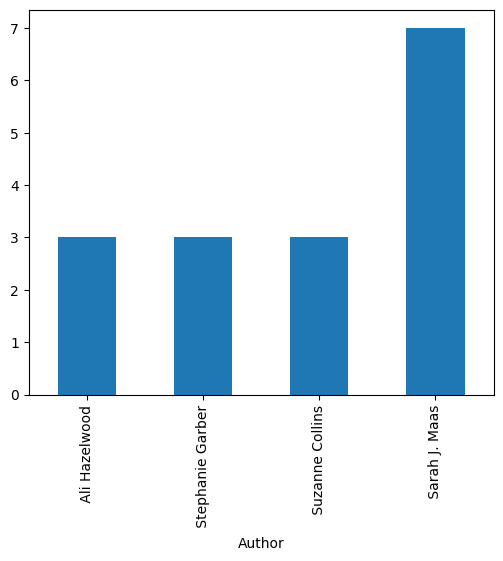

In [ ]:
occu2 = occu[occu > 2].sort_values()
plt.figure(figsize=(6,5))
occu2.plot(kind='bar')
plt.show()

- Visualizaion for number of books published each year

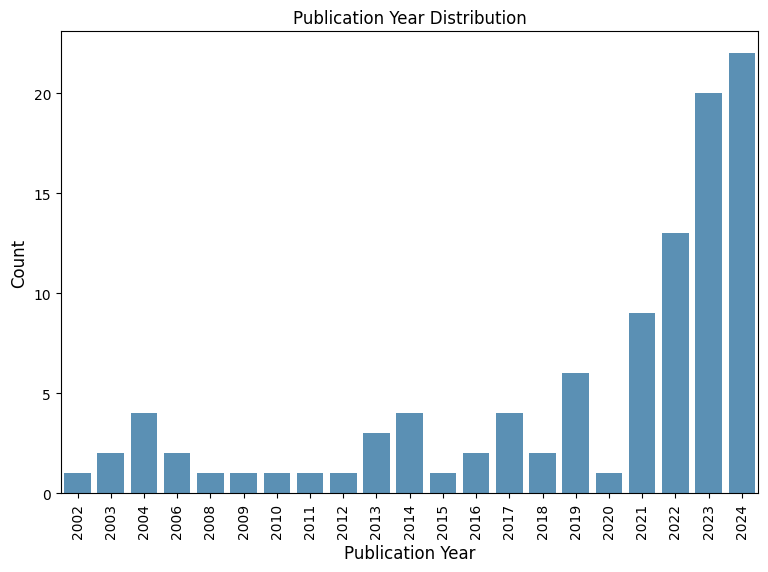

In [ ]:
plt.figure(figsize=(9,6))
ax = sns.barplot(x=df_clean['publication year'].value_counts().index,
                 y=df_clean['publication year'].value_counts().values,
                 alpha=0.8)
plt.title("Publication Year Distribution")
plt.xlabel('Publication Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- The category that occured the most

<ipython-input-122-21927b0d1a7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette="viridis")


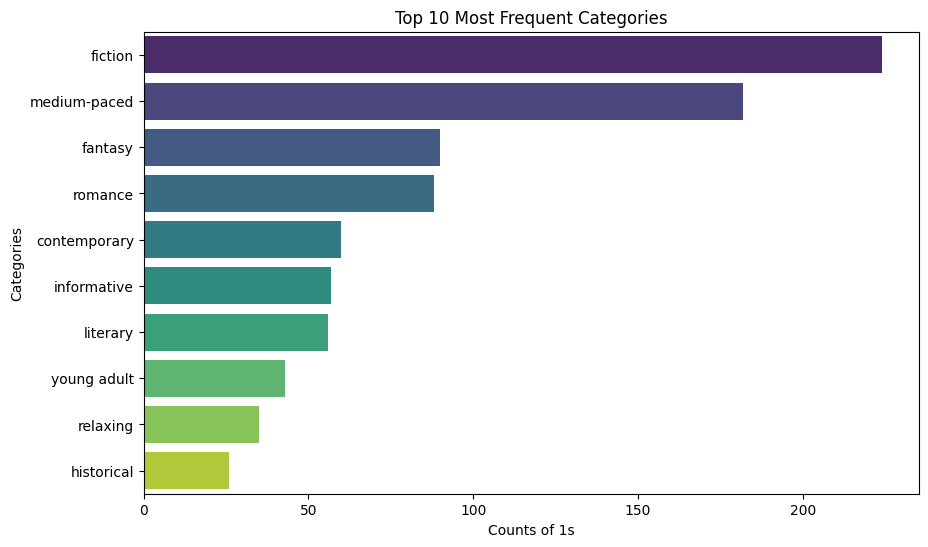

adventurous             12.0
challenging              9.0
classics                13.0
contemporary            60.0
crime                    6.0
dark                    12.0
dystopian               14.0
emotional                0.0
erotica                  3.0
fantasy                 90.0
fiction                224.0
food and drink           1.0
funny                   13.0
graphic novel            1.0
historical              26.0
hopeful                  7.0
horror                   4.0
informative             57.0
inspiring               13.0
lgbtqia+                26.0
lighthearted            22.0
literary                56.0
magical realism          4.0
medium-paced           182.0
memoir                   5.0
middle grade             2.0
music                    1.0
mysterious               9.0
mystery                 17.0
nonfiction               7.0
psychology               1.0
reflective               6.0
relaxing                35.0
romance                 88.0
sad           

In [ ]:
selected_columns = ['adventurous', 'challenging', 'classics', 'contemporary', 'crime', 'dark', 'dystopian',
  'emotional', 'erotica', 'fantasy', 'fiction', 'food and drink', 'funny', 'graphic novel', 'historical', 'hopeful',
  'horror', 'informative', 'inspiring', 'lgbtqia+', 'lighthearted','literary', 'magical realism', 'medium-paced',
  'memoir', 'middle grade', 'music', 'mysterious', 'mystery', 'nonfiction', 'psychology', 'reflective', 'relaxing',
  'romance', 'sad', 'science fiction', 'self help', 'slow-paced', 'speculative fiction', 'sports', 'tense', 'thriller', 'young adult'
]

# Ensure the selected columns exist in the DataFrame to avoid errors
selected_columns = [col for col in selected_columns if col in df.columns]

# Count the number of times `1` appears in each selected column
counts = df[selected_columns].apply(pd.value_counts).loc[1].fillna(0)

# Sort the counts and select the top 10
top_counts = counts.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts.values, y=top_counts.index, palette="viridis")
plt.title('Top 10 Most Frequent Categories')
plt.xlabel('Counts of 1s')
plt.ylabel('Categories')
plt.show()

# Print the counts
print(counts)

- Visualizing Publishers with most publications in recent Years

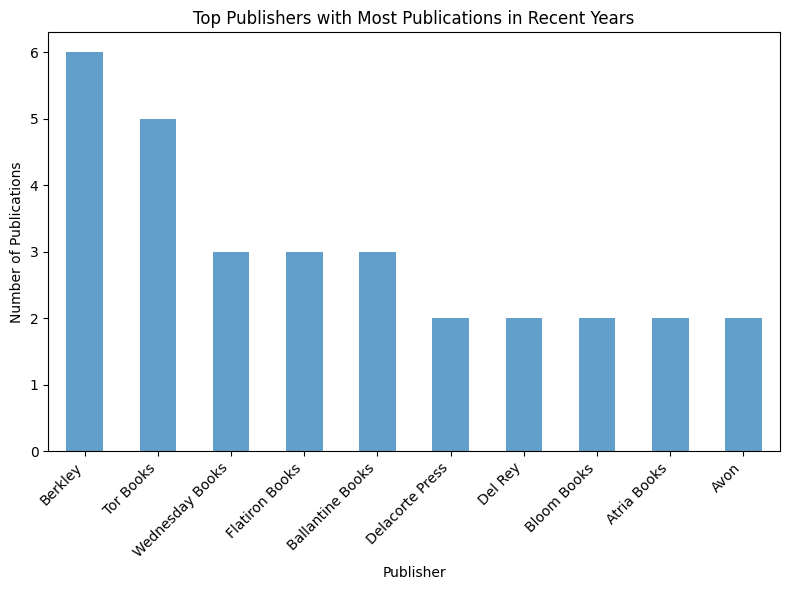

In [ ]:
# Filter DataFrame for recent years (e.g., last 5 years)
recent_years = df_clean[df_clean['publication year'] >= 2020]

# Count the occurrences of each publisher in recent years
publisher_counts = recent_years['Publisher'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
publisher_counts.head(10).plot(kind='bar', alpha=0.7)
plt.title("Top Publishers with Most Publications in Recent Years")
plt.xlabel("Publisher")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

- Number of Publications Released Each Month

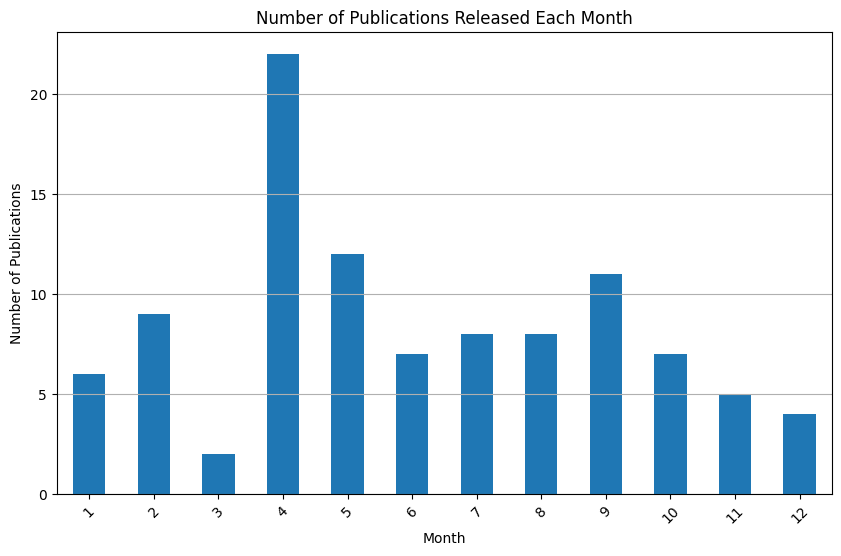

The month with the most publication releases is: 4


In [ ]:
# Count the number of publications released in each month
monthly_counts = df_clean['Month'].value_counts().sort_index()

# Create a plot of publication counts per month
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar')
plt.title('Number of Publications Released Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Determine which month has the highest count of publication releases
most_common_month = monthly_counts.idxmax()

# Show the plot
plt.show()

# Print the most common month
print("The month with the most publication releases is:", most_common_month)

# Building Models to Predict Average Rating

## Importing Libraries and Preprocessing the Dataset

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVR

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/storygraph_dataset(No Description).csv')

# Convert 'Publication Date' to datetime and extract components
data['Publication Date'] = pd.to_datetime(data['Publication Date'], errors='coerce')
data['Year'] = data['Publication Date'].dt.year
data['Month'] = data['Publication Date'].dt.month
data['DayOfWeek'] = data['Publication Date'].dt.dayofweek

# Frequency encoding for 'Format' and 'Publisher'
frequency_format = data['Format'].value_counts(normalize=True)
data['Format_Freq'] = data['Format'].map(frequency_format)
frequency_publisher = data['Publisher'].value_counts(normalize=True)
data['Publisher_Freq'] = data['Publisher'].map(frequency_publisher)

# Create text features from 'Title'
data['Title_Length'] = data['Title'].apply(len)

# Prepare the feature matrix and target vector
X = data.drop(columns=['Title', 'Author', 'Publisher', 'Publication Date', 'Average Rating', 'Format'])
y = data['Average Rating']

# Define columns that need to be scaled and encoded
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create a column transformer to handle scaling and encoding
column_transformer = ColumnTransformer(
    [('num', SimpleImputer(strategy='median'), numeric_features),
     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# Apply transformations
X_processed = column_transformer.fit_transform(X)

# Scale all features without centering (suitable for sparse matrices)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_processed)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Baseline Model
Linear Regression

MSE: 0.0599, R-squared: -0.0419

In [ ]:
# Preparing the feature matrix and target vector
X = data.drop(columns=['Title', 'Author', 'Publisher', 'Publication Date', 'Average Rating'])
y = data['Average Rating']

# Identifying categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

# Imputing missing values for numeric columns with the median, and categorical with the most frequent value
imputer_numeric = SimpleImputer(strategy='median')
imputer_categorical = SimpleImputer(strategy='most_frequent')

X_numeric_imputed = imputer_numeric.fit_transform(X[numeric_cols])
X_categorical = X[categorical_cols].fillna('Missing')  # Replace NaN with a placeholder
X_categorical_encoded = pd.get_dummies(X_categorical)

# Combining numeric and categorical data
X_processed = np.hstack((X_numeric_imputed, X_categorical_encoded.values))

# Scaling the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.0598827051524852
R-squared: -0.041867343822085346


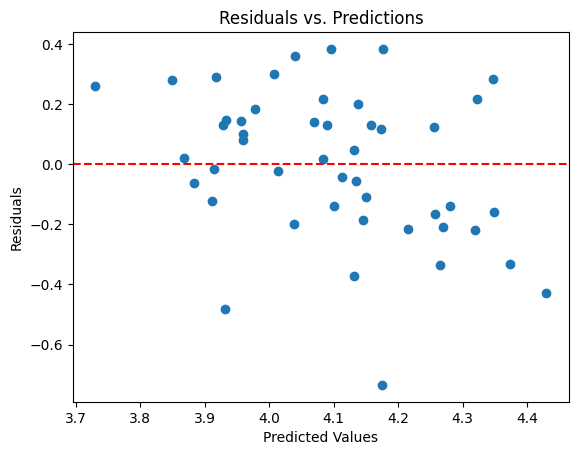

In [ ]:
predictions = model.predict(X_test)
residuals = y_test - predictions

plt.scatter(predictions, residuals)
plt.title('Residuals vs. Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
predictions = model.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculating MAE
mae = mean_absolute_error(y_test, predictions)

# Printing the results
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))


Root Mean Squared Error (RMSE): 0.2447
Mean Absolute Error (MAE): 0.2009


## Best Two Models

### 1. Gradient Boosting MSE: 0.0293, R-squared: 0.4898
'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400

In [ ]:
# Initialize and train the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict and evaluate the models
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
print("Random Forest MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, rf_pred), r2_score(y_test, rf_pred)))
print("Gradient Boosting MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, gb_pred), r2_score(y_test, gb_pred)))

# Parameter Tuning using Grid Search for Gradient Boosting
param_grid = {'n_estimators': [100, 200, 250, 300, 350, 400], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 10, 15, 20, 25, 30]}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_gb_model = grid_search.best_estimator_

# Predict and evaluate the best model from grid search
best_gb_pred = best_gb_model.predict(X_test)
print("Optimized Gradient Boosting MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, best_gb_pred), r2_score(y_test, best_gb_pred)))

Random Forest MSE: 0.0377, R-squared: 0.3448
Gradient Boosting MSE: 0.0326, R-squared: 0.4325
Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.1s
[CV] END ..learning_rate=0.05, ma

In [ ]:
# Printing the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}


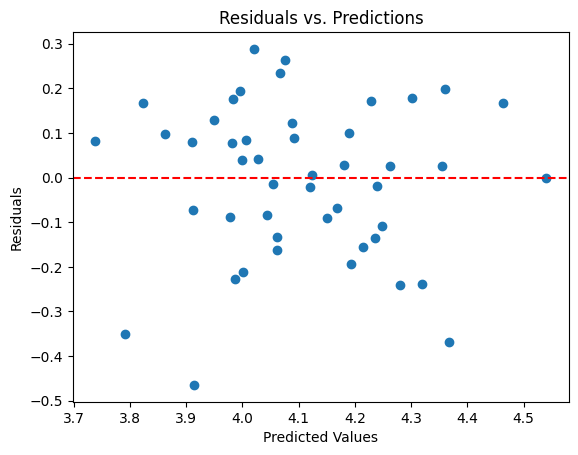

In [ ]:
predictions = best_gb_model.predict(X_test)
residuals = y_test - predictions

plt.scatter(predictions, residuals)
plt.title('Residuals vs. Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
predictions = best_gb_model.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculating MAE
mae = mean_absolute_error(y_test, predictions)

# Printing the results
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))

Root Mean Squared Error (RMSE): 0.1712
Mean Absolute Error (MAE): 0.1386


### 2. Gradient Boosting MSE: 0.0310, R-squared: 0.4610
'learning_rate': 0.23, 'max_depth': 1, 'n_estimators': 500:

In [ ]:
# Creating the model
model = GradientBoostingRegressor()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.21, 0.22, 0.23, 0.24]
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model
best_model_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_model_pred)
r2 = r2_score(y_test, best_model_pred)
print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(mse, r2))
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=400; total time=   0.4s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=400; total time=   0.4s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=400; total time=   0.4s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=400; total time=   0.4s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=400; total time=   0.4s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.21, max_depth=1, n_estimators=600; total time=   0.6s
[CV] END ..learning_rate=0.21, max_depth=1, n_e

## Other Models:

## Support Vector Regression

### SVR MSE: 0.0578, R-squared: -0.0061

In [ ]:
# Prepare feature matrix and target vector
X = data[['Page Count', 'Number of Reviews', 'tense', 'adventurous', 'emotional',
          'inspiring', 'funny', 'medium_pace', 'slow_pace', 'Title_Length']]
y = data['Average Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVR
model = SVR()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

Mean Squared Error:  0.057825997999924925
R-squared: -0.006083789745805701


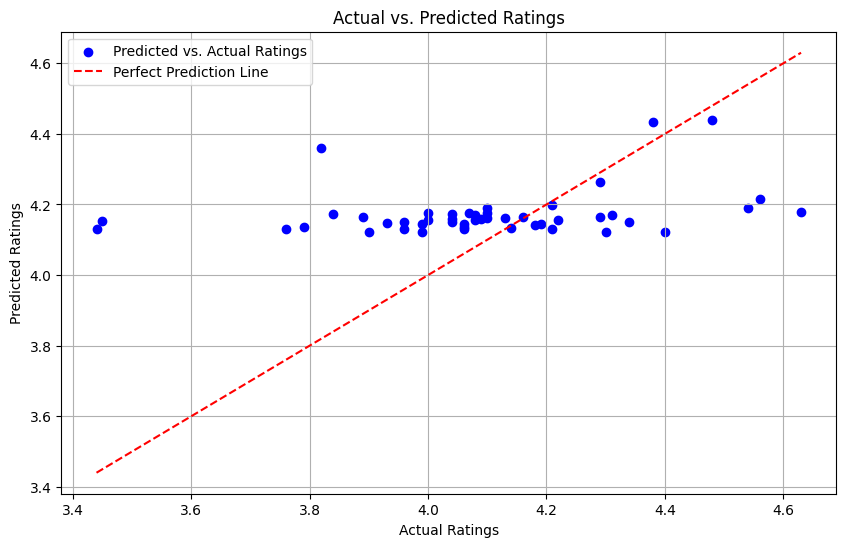

In [ ]:
# Calculate the range for the plot
min_rating = min(y_test.min(), y_pred.min())
max_rating = max(y_test.max(), y_pred.max())

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. Actual Ratings')
plt.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosting and Random Forest

### Random Forest MSE: 0.0357, R-squared: 0.3789

Feature Selection

In [ ]:
# Exclude non-numeric and high cardinality columns
numeric_and_encoded_data = data.drop(columns=[
    'Title', 'Author', 'Format', 'Publisher', 'Publication Date',
    'Graphic CW', 'Moderate CW', 'Minor CW'
])

# Prepare feature matrix and target vector
X = numeric_and_encoded_data.drop(columns=['Average Rating'])
y = numeric_and_encoded_data['Average Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# List to store the best features
best_features = []
best_score = float('inf')

# Loop over different numbers of features to select
for n in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = mean_squared_error(y_test, y_pred)
    if score < best_score:
        best_score = score
        best_features = X_train.columns[rfe.support_]

# Print the best combination of features and the corresponding score
print("Best features:\n", best_features)
print("Best MSE:", best_score)

Best features:
 Index(['Page Count', 'Number of Reviews', 'tense', 'adventurous', 'emotional',
       'inspiring', 'funny', 'medium_pace', 'slow_pace', 'Title_Length'],
      dtype='object')
Best MSE: 0.03570137808510649


In [ ]:
# Prepare feature matrix and target vector
X = data[['Page Count', 'Number of Reviews', 'tense', 'adventurous', 'emotional',
          'inspiring', 'funny', 'medium_pace', 'slow_pace', 'Title_Length']]
y = data['Average Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

Mean Squared Error:  0.03570137808510649
R-squared: 0.3788507072016565


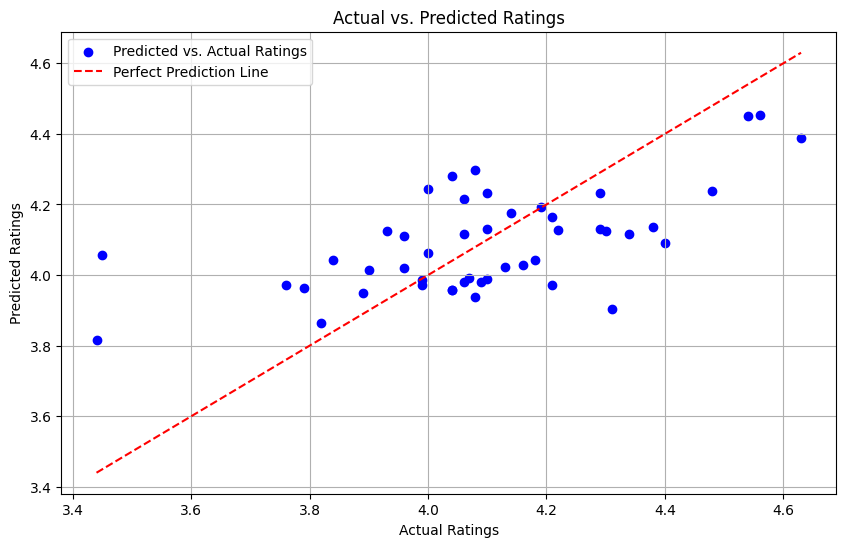

In [ ]:
# Calculate the range for the plot
min_rating = min(y_test.min(), y_pred.min())
max_rating = max(y_test.max(), y_pred.max())

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. Actual Ratings')
plt.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()

### Optimized Gradient Boosting MSE: 0.0312, R-squared: 0.4563
Random Forest MSE: 0.0377, R-squared: 0.3448

Gradient Boosting MSE: 0.0326, R-squared: 0.4325


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/storygraph_dataset(No Description).csv')

# Convert 'Publication Date' to datetime and extract components
data['Publication Date'] = pd.to_datetime(data['Publication Date'], errors='coerce')
data['Year'] = data['Publication Date'].dt.year
data['Month'] = data['Publication Date'].dt.month
data['DayOfWeek'] = data['Publication Date'].dt.dayofweek

# Frequency encoding for 'Format' and 'Publisher'
frequency_format = data['Format'].value_counts(normalize=True)
data['Format_Freq'] = data['Format'].map(frequency_format)
frequency_publisher = data['Publisher'].value_counts(normalize=True)
data['Publisher_Freq'] = data['Publisher'].map(frequency_publisher)

# Create text features from 'Title'
data['Title_Length'] = data['Title'].apply(len)

# Prepare the feature matrix and target vector
X = data.drop(columns=['Title', 'Author', 'Publisher', 'Publication Date', 'Average Rating', 'Format'])
y = data['Average Rating']

# Define columns that need to be scaled and encoded
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create a column transformer to handle scaling and encoding
column_transformer = ColumnTransformer(
    [('num', SimpleImputer(strategy='median'), numeric_features),
     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# Apply transformations
X_processed = column_transformer.fit_transform(X)

# Scale all features without centering (suitable for sparse matrices)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_processed)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict and evaluate the models
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
print("Random Forest MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, rf_pred), r2_score(y_test, rf_pred)))
print("Gradient Boosting MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, gb_pred), r2_score(y_test, gb_pred)))

# Parameter Tuning using Grid Search for Gradient Boosting
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_gb_model = grid_search.best_estimator_

# Predict and evaluate the best model from grid search
best_gb_pred = best_gb_model.predict(X_test)
print("Optimized Gradient Boosting MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, best_gb_pred), r2_score(y_test, best_gb_pred)))


Random Forest MSE: 0.0377, R-squared: 0.3448
Gradient Boosting MSE: 0.0326, R-squared: 0.4325
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.6s
[CV] END ..learning_rate=0.05, max_

### Gradient Boosting MSE: 0.0337, R-squared: 0.4132
'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100

In [ ]:
# Defining model creation function
def create_model(hidden_layers=2, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Creating the model
model = GradientBoostingRegressor()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.2, 0.3]
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model
best_model_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_model_pred)
r2 = r2_score(y_test, best_model_pred)
print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(mse, r2))
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=4, n_e

### Gradient Boosting MSE: 0.0319, R-squared: 0.4444
'learning_rate': 0.23, 'max_depth': 2, 'n_estimators': 500

In [ ]:
# Creating the model
model = GradientBoostingRegressor()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [0.5, 2, 4],
    'learning_rate': [0.2, 0.23, 0.25]
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model
best_model_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_model_pred)
r2 = r2_score(y_test, best_model_pred)
print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(mse, r2))
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=100; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=300; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=300; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=300; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=300; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=300; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_estimators=500; total time=   0.0s
[CV] END .learning_rate=0.2, max_depth=0.5, n_e

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best Model MSE: 0.0319, R-squared: 0.4444
Best Hyperparameters: {'learning_rate': 0.23, 'max_depth': 2, 'n_estimators': 500}


### Gradient Boosting MSE: 0.0465, R-squared: 0.1902
'learning_rate': 0.23, 'max_depth': 300, 'n_estimators': 4

In [ ]:
# Creating the model
model = GradientBoostingRegressor()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [4, 500, 2000],
    'max_depth': [50, 100, 300],
    'learning_rate': [0.23]
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model
best_model_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_model_pred)
r2 = r2_score(y_test, best_model_pred)
print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(mse, r2))
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...learning_rate=0.23, max_depth=50, n_estimators=4; total time=   0.0s
[CV] END ...learning_rate=0.23, max_depth=50, n_estimators=4; total time=   0.0s
[CV] END ...learning_rate=0.23, max_depth=50, n_estimators=4; total time=   0.0s
[CV] END ...learning_rate=0.23, max_depth=50, n_estimators=4; total time=   0.0s
[CV] END ...learning_rate=0.23, max_depth=50, n_estimators=4; total time=   0.0s
[CV] END .learning_rate=0.23, max_depth=50, n_estimators=500; total time=   0.7s
[CV] END .learning_rate=0.23, max_depth=50, n_estimators=500; total time=   0.7s
[CV] END .learning_rate=0.23, max_depth=50, n_estimators=500; total time=   0.7s
[CV] END .learning_rate=0.23, max_depth=50, n_estimators=500; total time=   0.7s
[CV] END .learning_rate=0.23, max_depth=50, n_estimators=500; total time=   0.7s
[CV] END learning_rate=0.23, max_depth=50, n_estimators=2000; total time=   1.5s
[CV] END learning_rate=0.23, max_depth=50, n_esti

### Gradient Boosting MSE: 0.0329, R-squared: 0.4276
'learning_rate': 0.23, 'max_depth': 2, 'n_estimators': 400

In [ ]:
# Creating the model
model = GradientBoostingRegressor()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [5, 400],
    'max_depth': [2, 200],
    'learning_rate': [0.23]
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model
best_model_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_model_pred)
r2 = r2_score(y_test, best_model_pred)
print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(mse, r2))
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....learning_rate=0.23, max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ....learning_rate=0.23, max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ....learning_rate=0.23, max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ....learning_rate=0.23, max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ....learning_rate=0.23, max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ..learning_rate=0.23, max_depth=2, n_estimators=400; total time=   0.6s
[CV] END ..learning_rate=0.23, max_depth=2, n_estimators=400; total time=   0.6s
[CV] END ..learning_rate=0.23, max_depth=2, n_estimators=400; total time=   0.6s
[CV] END ..learning_rate=0.23, max_depth=2, n_estimators=400; total time=   0.6s
[CV] END ..learning_rate=0.23, max_depth=2, n_estimators=400; total time=   0.6s
[CV] END ..learning_rate=0.23, max_depth=200, n_estimators=5; total time=   0.0s
[CV] END ..learning_rate=0.23, max_depth=200, n_e

## Neural Networks

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

### Neural Network MSE: 3.6668, R-squared: -62.7966

In [ ]:
# Build and train a Feedforward Neural Network (FNN)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Evaluate the model
nn_pred = model.predict(X_test)
print("Neural Network MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, nn_pred), r2_score(y_test, nn_pred)))

Epoch 1/100
12/12 [==============================] - 3s 3ms/step - loss: 128.9821
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 63.0391
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 36.8270
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 31.5172
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 25.5366
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 21.1280
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 13.1627
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 14.0756
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 9.0043
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 8.1592
Epoch 11/100
12/12 [==============================] - 0s 3ms/step - loss: 7.3207
Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 7.3680
Epoch 13/100
12/12 [========

### Neural Network MSE: 3.3337, R-squared: -57.0019

In [ ]:
# Build and train a Feedforward Neural Network (FNN)
model = Sequential()
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

# Evaluate the model
nn_pred = model.predict(X_test)
print("Neural Network MSE: {:.4f}, R-squared: {:.4f}".format(mean_squared_error(y_test, nn_pred), r2_score(y_test, nn_pred)))

Epoch 1/500
6/6 [==============================] - 1s 3ms/step - loss: 22.0621
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 13.4725
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 7.2537
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 7.1718
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 5.0609
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 3.6177
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 2.7125
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 2.5188
Epoch 9/500
6/6 [==============================] - 0s 3ms/step - loss: 2.5984
Epoch 10/500
6/6 [==============================] - 0s 3ms/step - loss: 1.9413
Epoch 11/500
6/6 [==============================] - 0s 3ms/step - loss: 2.0229
Epoch 12/500
6/6 [==============================] - 0s 3ms/step - loss: 1.8387
Epoch 13/500
6/6 [==============================] - 0s 3ms/

### NN Best Model MSE: 1.0969, R-squared: -18.0842

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [2, 3],
    'neurons': [64, 128],
    'dropout_rate': [0.3, 0.5]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model

print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step
Best Model MSE: 1.0969, R-squared: -18.0842


### NN Best Model MSE: 0.6212, R-squared: -9.8080
'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.3

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings

# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [2, 3],
    'neurons': [64, 128],
    'dropout_rate': [0.3, 0.5]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 4ms/step
Best Model MSE: 0.6212, R-squared: -9.8080
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.3}


### NN Best Model MSE: 0.1336, R-squared: -1.3246
'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.1

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [1, 2, 4],
    'neurons': [128, 264],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 3ms/step
Best Model MSE: 0.1336, R-squared: -1.3246
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 128, 'dropout_rate': 0.1}


### NN Best Model MSE: 0.0736, R-squared: -0.2812
'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.05

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [2, 5],
    'neurons': [32, 128, 256],
    'dropout_rate': [0.05, 0.1]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 3ms/step
NN Best Model MSE: 0.0736, R-squared: -0.2812
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.05}


### NN Best Model MSE: 0.0734, R-squared: -0.2772
'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.05

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [1, 2, 4],
    'neurons': [128, 256, 512],
    'dropout_rate': [0.25, 0.05, 0.75]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 4ms/step
NN Best Model MSE: 0.0734, R-squared: -0.2772
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.05}


### NN Best Model MSE: 0.0637, R-squared: -0.1088
'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.025

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [1, 2, 3, 4],
    'neurons': [256],
    'dropout_rate': [0.025, 0.05, 0.075]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 4ms/step
NN Best Model MSE: 0.0637, R-squared: -0.1088
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.025}


### NN Best Model MSE: 0.0945, R-squared: -0.6439
'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.03

In [ ]:
# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [2],
    'neurons': [256],
    'dropout_rate': [0.01, 0.025, 0.03]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 4ms/step
NN Best Model MSE: 0.0945, R-squared: -0.6439
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.03}


### NN Best Model MSE: 0.0734, R-squared: -0.2773
'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.03

In [ ]:
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings

# Define a function to create the neural network model with specified hyperparameters
def create_model(hidden_layers=2, neurons=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout layers for regularization
    model.add(Dropout(dropout_rate))

    # Add hidden layers
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Define hyperparameters for tuning
param_grid = {
    'hidden_layers': [2],
    'neurons': [256, 1024],
    'dropout_rate': [0.025, 0.03, 0.04]
}

# Perform GridSearchCV to find the best combination of hyperparameters
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None
best_params = {}

for hidden_layers in param_grid['hidden_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            # Create the model
            model = create_model(hidden_layers=hidden_layers, neurons=neurons, dropout_rate=dropout_rate)

            # Train the model
            model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

            # Evaluate the model
            nn_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, nn_pred)
            r2 = r2_score(y_test, nn_pred)

            # Check if current model has lower MSE and higher R-squared
            if mse < best_mse and r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_model = model
                best_params = {'hidden_layers': hidden_layers, 'neurons': neurons, 'dropout_rate': dropout_rate}

print("NN Best Model MSE: {:.4f}, R-squared: {:.4f}".format(best_mse, best_r2))
print("Best Hyperparameters:", best_params)

2/2 [==============================] - 0s 3ms/step
NN Best Model MSE: 0.0734, R-squared: -0.2773
Best Hyperparameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.03}
